# Spatial analysis between Epithelial vs Fibroblast

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import sys, os
import anndata as ad
import squidpy as sq

other_dir_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(other_dir_path)

import IMCprocess.spatial_analysis.spatial_analysis as sa
import IMCprocess.spatial_analysis.combi_enrich as ce
import IMCprocess.utils.utils as ut

# I have to use custom Img_anndata code
import Img_anndata as utan

## Download Epithelial and Fibroblast object

In [2]:
Ep2 = ut.read_pickle_obj('../make_input_imacyte/sample_data/02hanna_adata_Patient9_obj_EpLevel2.pkl')
Fi2 = ut.read_pickle_obj('../make_input_imacyte/sample_data/02hanna_adata_Patient9_obj_Level2.pkl')

In [3]:
Ep_adata = Ep2.adata_dict['Ep_level2']
Fi_adata = Fi2.adata_dict['Fibro_level2']

## Merge Epi and Fibro

In [4]:
def merge_adata(Ep_adata, Fi_adata):
    Ep_adata.obs['level2_annotated']=Ep_adata.obs['level1_annotated'].str.cat(
        Ep_adata.obs['Ep_level2_annotated'], sep='_').astype('category')

    Fi_adata.obs['level2_annotated']=Fi_adata.obs['level1_annotated'].str.cat(
        Fi_adata.obs['Fibro_level2_annotated'], sep='_').astype('category')

    Epi_Fi_adata = ad.concat([Ep_adata, Fi_adata])
    return(Epi_Fi_adata)

In [5]:
Epi_Fi_adata = merge_adata(Ep_adata, Fi_adata)

In [6]:
Epi_Fi_adata[Epi_Fi_adata.obs['img_id'] == 'R1_001']

View of AnnData object with n_obs × n_vars = 3469 × 36
    obs: 'img_id', 'PhenoGraph_clusters', 'level1_annotated', 'level2_annotated'
    obsm: 'spatial', 'X_pca', 'X_umap'

## Plot spatial for Epithelial and Fibroblast

In [7]:
def plt_spatial(adata, marker, output_path,name):
    fig = sc.pl.spatial(adata, color=marker,    
                        title=[name+' '+marker],
                        return_fig=True,
                  #save = output_path + '/' + marker+ '_' + name +'.png',
                        spot_size=10, show = False)
    fig2 = fig[0].get_figure()
    fig2.tight_layout()
    fig2.savefig(output_path+marker+'_'+name+'_spatial.png', dpi = 300)

/Users/pattama/Desktop/UiB/venv_folder/IMCprocess_venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/pattama/Desktop/UiB/venv_folder/IMCprocess_venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/pattama/Desktop/UiB/venv_folder/IMCprocess_venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/pattama/Desktop/UiB/venv_folder/IMCprocess_venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/pattama/Desktop/UiB/venv_folder/IMCprocess_venv/lib/python3.8/site-packages/a

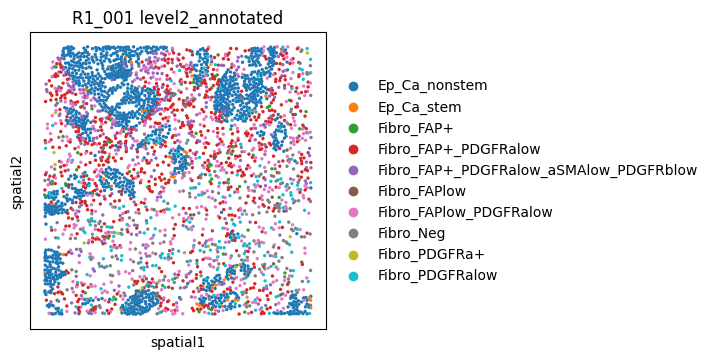

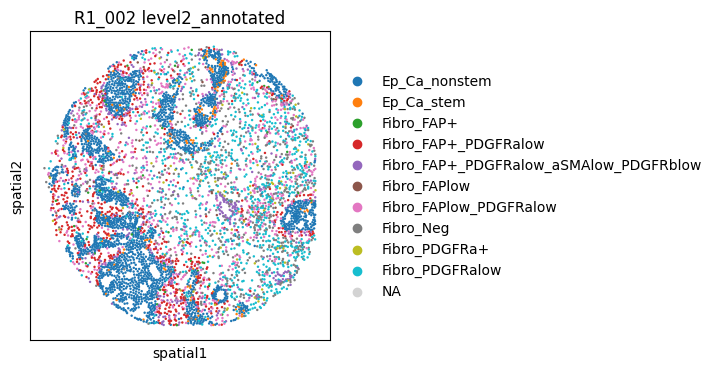

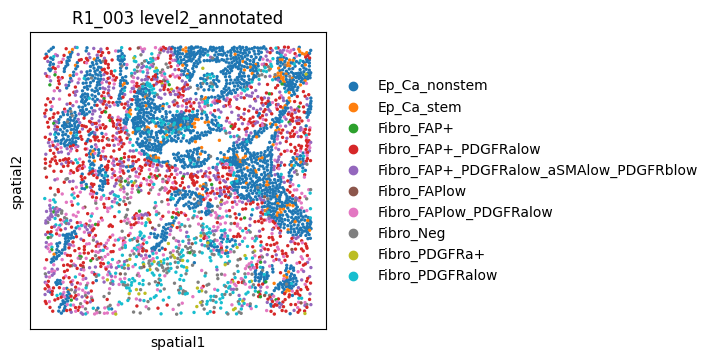

In [8]:
for img in Epi_Fi_adata.obs['img_id'].unique():
    img_adata = Epi_Fi_adata[Epi_Fi_adata.obs['img_id'] == img]
    plt_spatial(img_adata, 'level2_annotated', 'output/', img)

## Export number of cells into csv file

In [9]:
# all cells in all images
Epi_Fi_adata.obs['level2_annotated'].value_counts()

Ep_Ca_nonstem                             5528
Fibro_FAP+_PDGFRalow                      1992
Fibro_FAPlow_PDGFRalow                    1704
Fibro_PDGFRalow                           1471
Fibro_Neg                                 1199
Fibro_FAP+_PDGFRalow_aSMAlow_PDGFRblow    1166
Ep_Ca_stem                                 306
Fibro_PDGFRa+                              152
Fibro_FAP+                                 143
Fibro_FAPlow                                97
Name: level2_annotated, dtype: int64

In [10]:
# for each images
# The number of cell is exported to csv
for img in Epi_Fi_adata.obs['img_id'].unique():
    print(img)
    img_adata = Epi_Fi_adata[Epi_Fi_adata.obs['img_id'] == img]
    num_df = pd.DataFrame(img_adata.obs['level2_annotated'].value_counts(dropna=False).sort_index())
    print(num_df)
    num_df.to_csv('output/'+img+'_epi_fib_num_level2.csv')

R1_001
                                        level2_annotated
Ep_Ca_nonstem                                       1410
Ep_Ca_stem                                            38
Fibro_FAP+                                            62
Fibro_FAP+_PDGFRalow                                 665
Fibro_FAP+_PDGFRalow_aSMAlow_PDGFRblow               318
Fibro_FAPlow                                          40
Fibro_FAPlow_PDGFRalow                               476
Fibro_Neg                                            251
Fibro_PDGFRa+                                         13
Fibro_PDGFRalow                                      196
R1_002
                                        level2_annotated
Ep_Ca_nonstem                                       2369
Ep_Ca_stem                                           123
Fibro_FAP+                                            43
Fibro_FAP+_PDGFRalow                                 597
Fibro_FAP+_PDGFRalow_aSMAlow_PDGFRblow               413
Fibro_FAPlow     

## Neighborhood enrichment
* plot zscore heatmap
* plot pvalue heatmap

In [11]:
def run_spatial_nhood(adata, obs_col, radius):
    # add None to obs_col if there is nan in obs_col
    adata.obs[obs_col] = pd.Categorical(adata.obs[obs_col])
    if adata.obs[obs_col].isna().any():
        adata.obs[obs_col] = adata.obs[obs_col].cat.add_categories(['None'])
        adata.obs[obs_col].fillna('None', inplace=True)
       
    sq.gr.spatial_neighbors(adata, radius=radius,coord_type='generic')
    sq.gr.nhood_enrichment(adata, cluster_key=obs_col)

In [12]:
def plt_spatial_nhood(adata, obs_col, output_path, name, img_size=(8, 5)):
    plt.figure(figsize=img_size)
    sq.pl.nhood_enrichment(adata, cluster_key=obs_col,
                           annotate=True,
                           save=output_path + obs_col + '_' +
                           name + '_NH_enrich.png',
                           title=[name+' zscore '+obs_col],
                           dpi=300
                           )

In [13]:
def plt_spatial_pval(adata, obs_col, output_path, name, img_size=(8, 5)):
    plt.figure(figsize=img_size)
    sq.pl.nhood_enrichment(adata, 
                           cluster_key = obs_col, 
                           mode='pval', annotate=True,
                           save=output_path + obs_col + '_' + name + '_nh_enrich_pval.png',
                           title=[name+' p-value '+obs_col],
                           dpi=300)

In [14]:
import scipy.stats
def z_to_pvalue(z_array):
    df = pd.DataFrame(z_array)
    pval = scipy.stats.norm.sf(abs(df))
    return(pval)

/var/folders/_d/_v_3rt457zj_nkkxtccyqtth0000gn/T/ipykernel_96865/3906839198.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_col] = pd.Categorical(adata.obs[obs_col])
/Users/pattama/Desktop/UiB/venv_folder/IMCprocess_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:06<00:00, 152.96/s]
/var/folders/_d/_v_3rt457zj_nkkxtccyqtth0000gn/T/ipykernel_96865/3906839198.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_col] = pd.Categorical(adata.obs[obs_col])
100%|██████████| 1000/1000 [00:06<00:00, 153.75/s]
/var/folders/_d/_v_3rt457zj_nkkxtccyqtth0000gn/T/ipykernel_96865/3906839198.py:3: ImplicitModificationWarning: Trying to modify 

<Figure size 800x500 with 0 Axes>

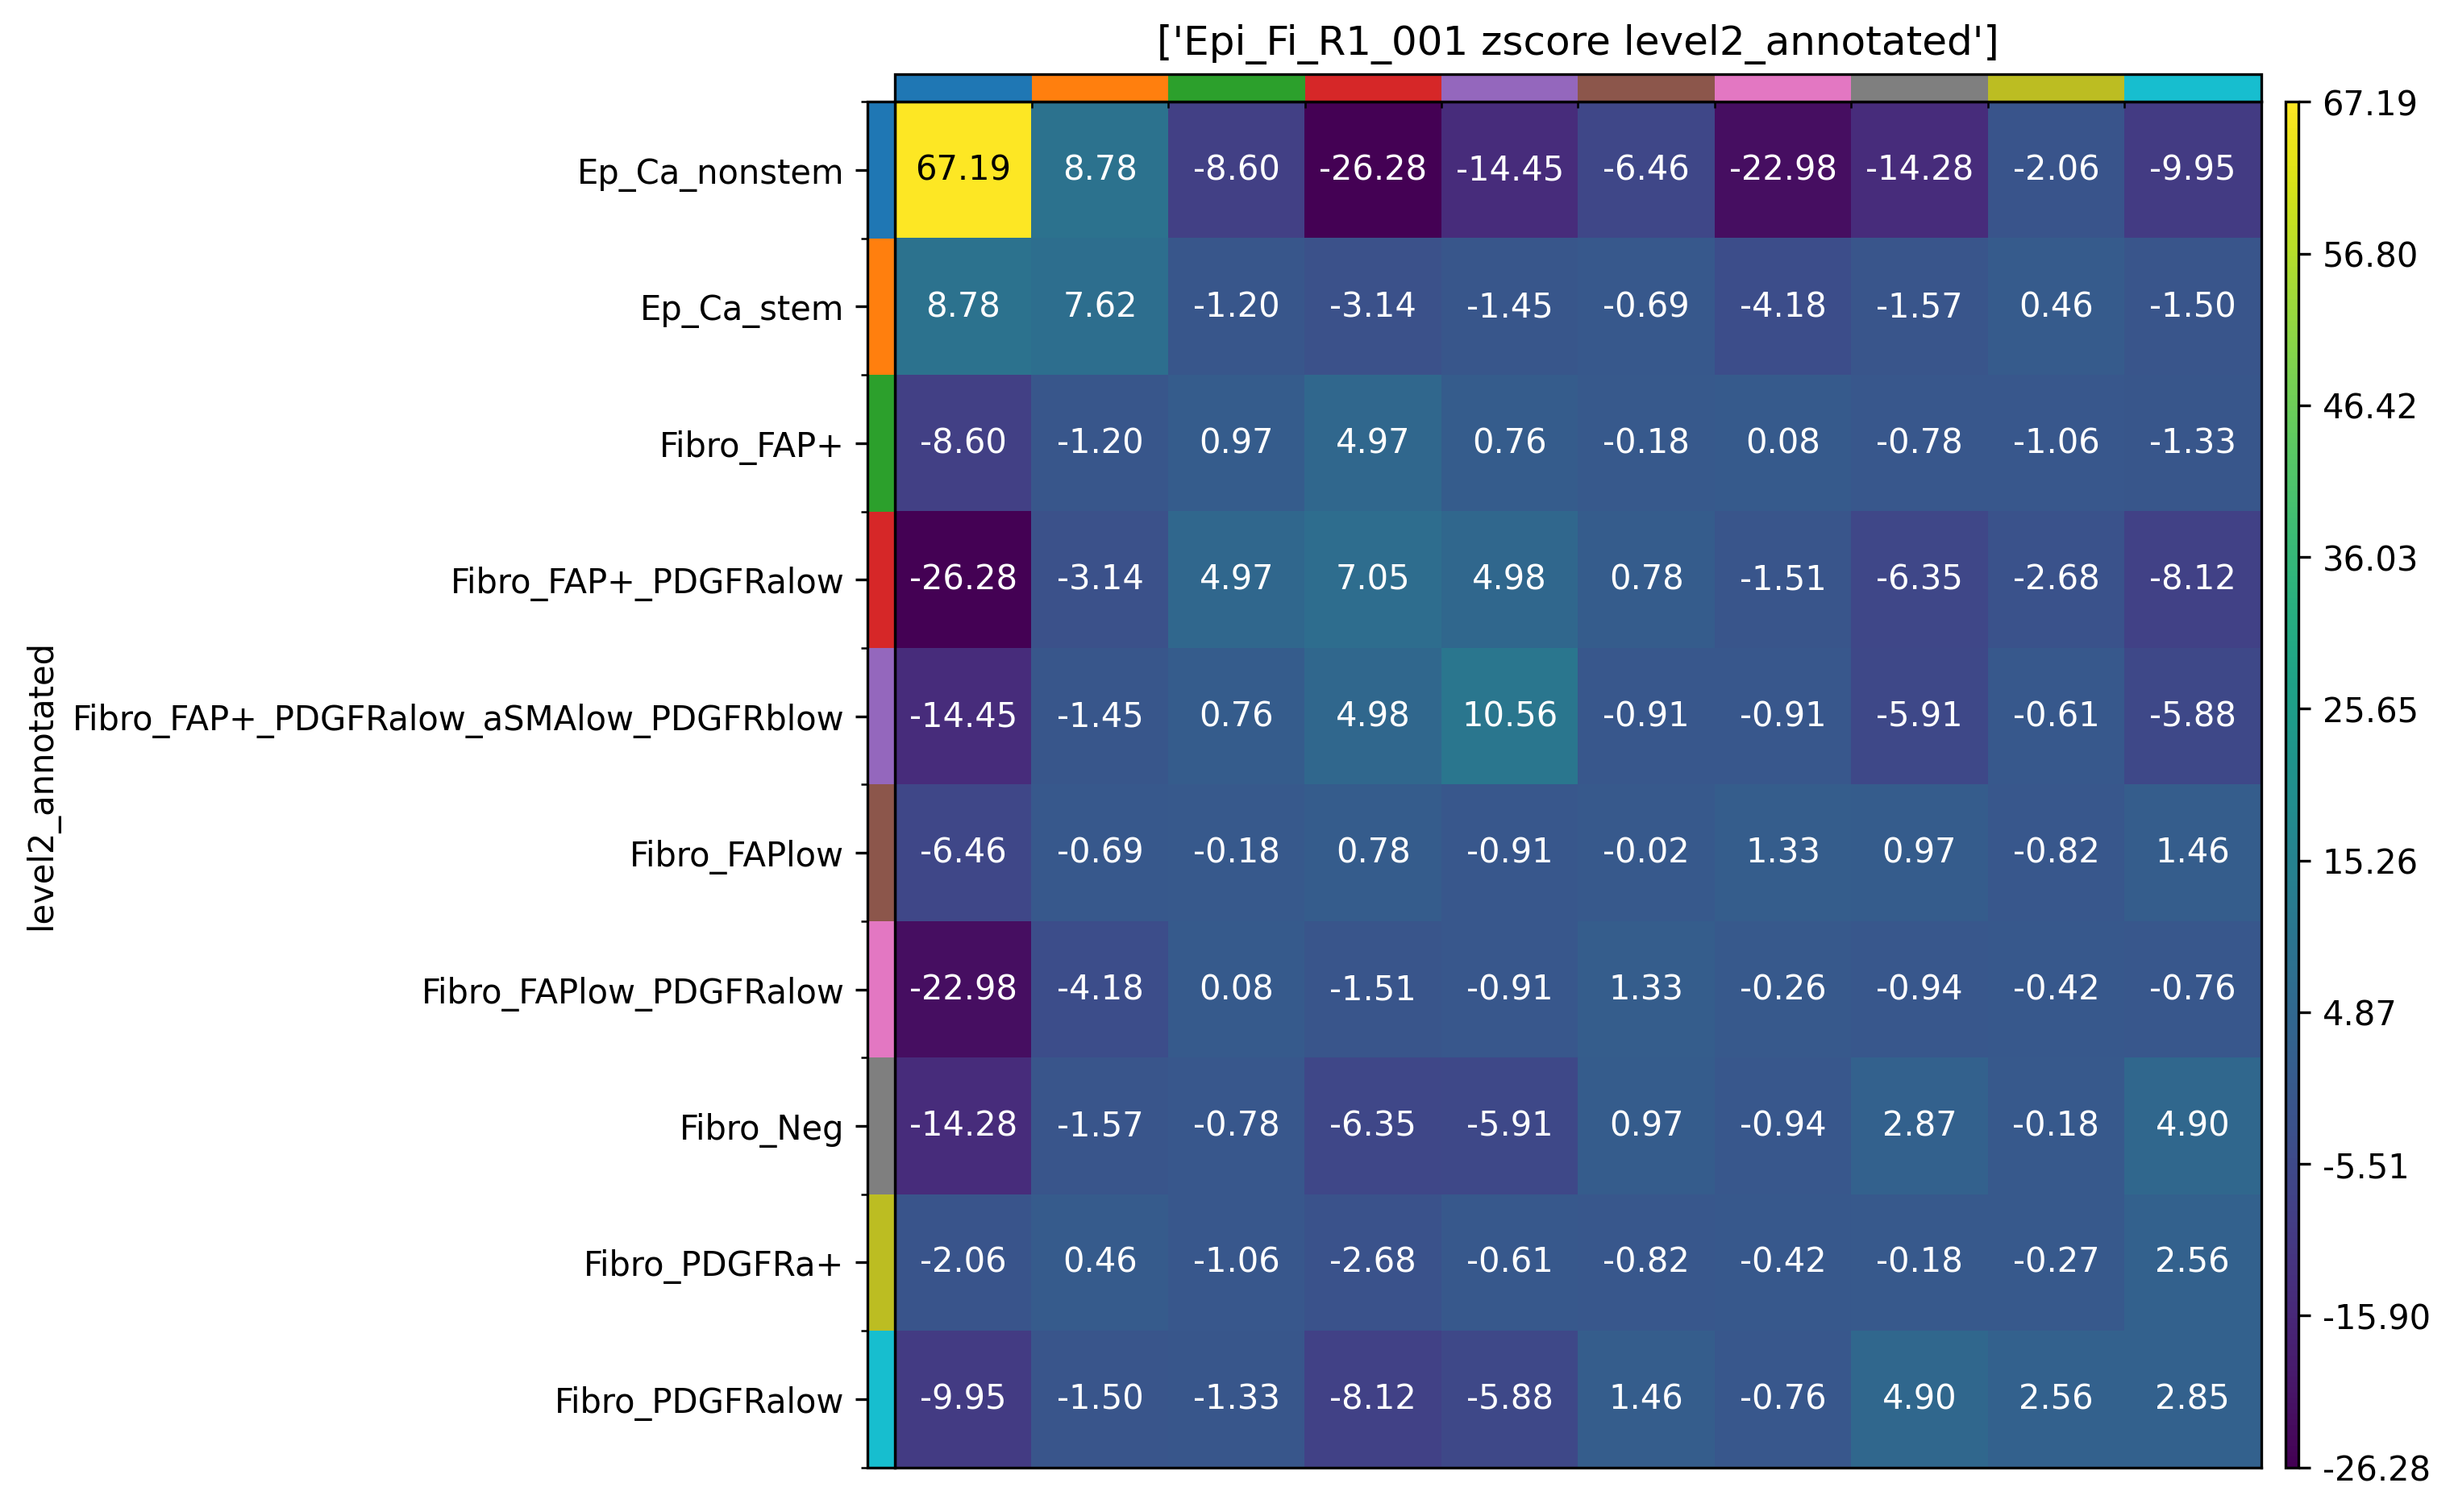

<Figure size 800x500 with 0 Axes>

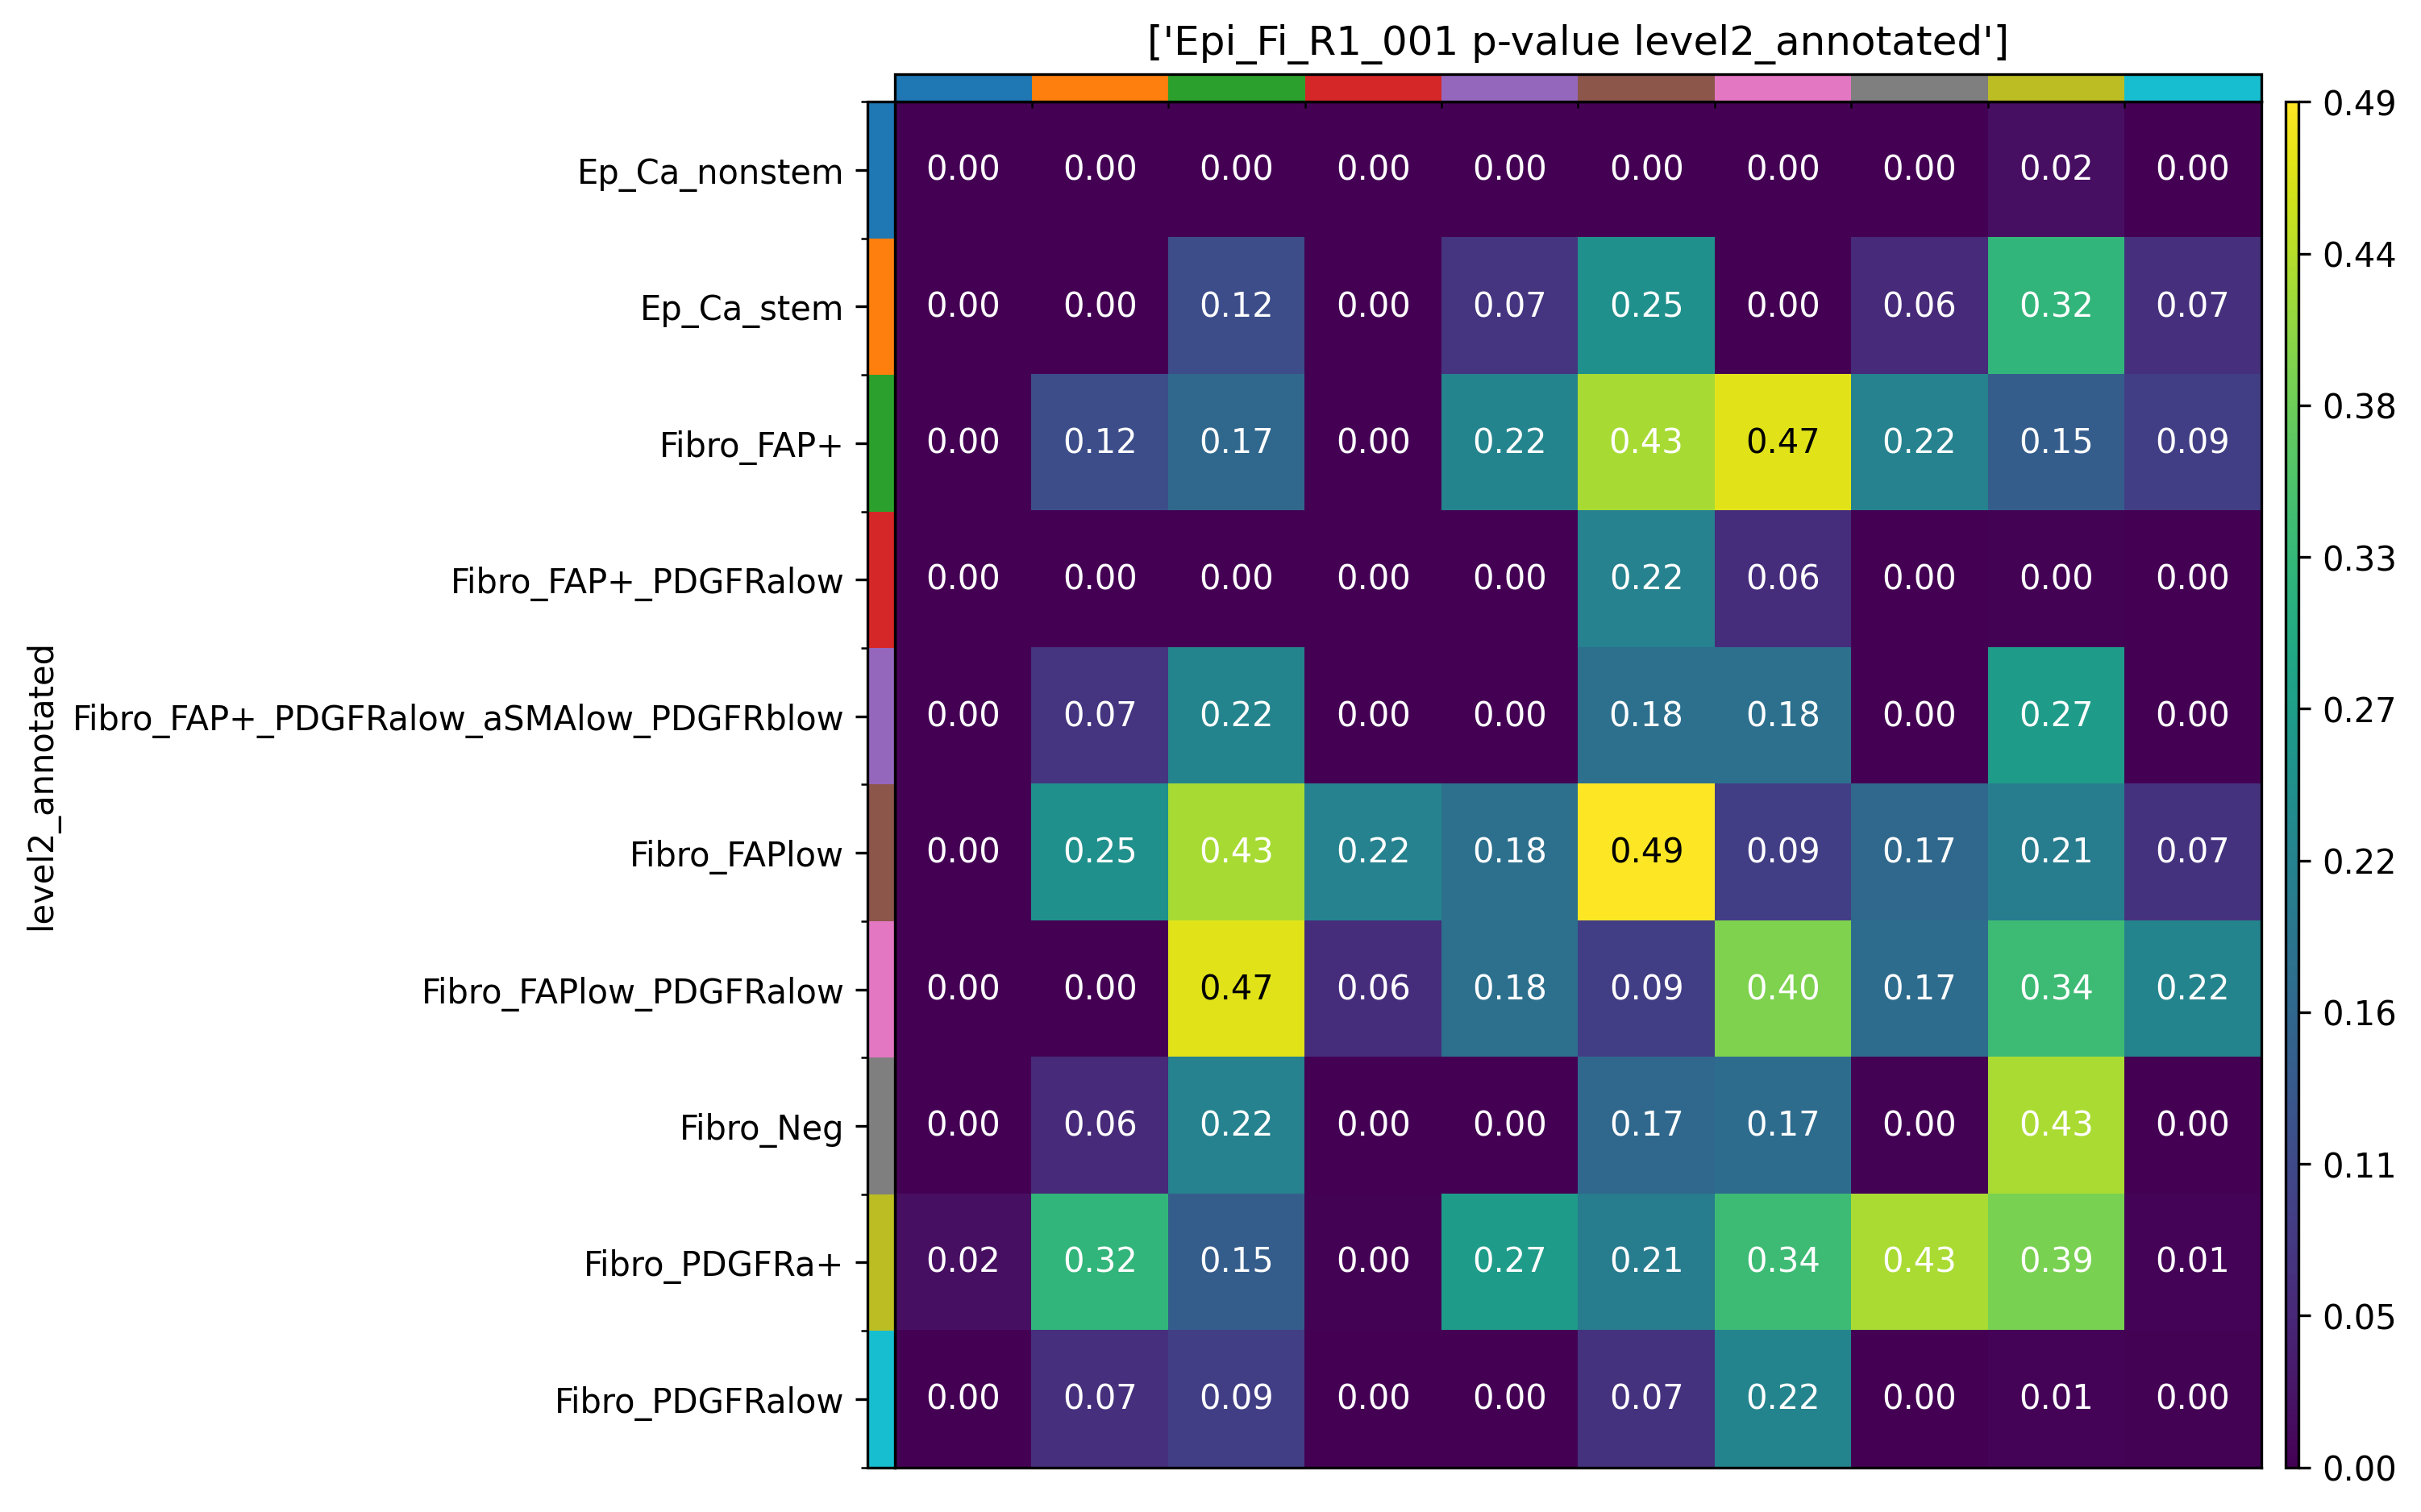

<Figure size 800x500 with 0 Axes>

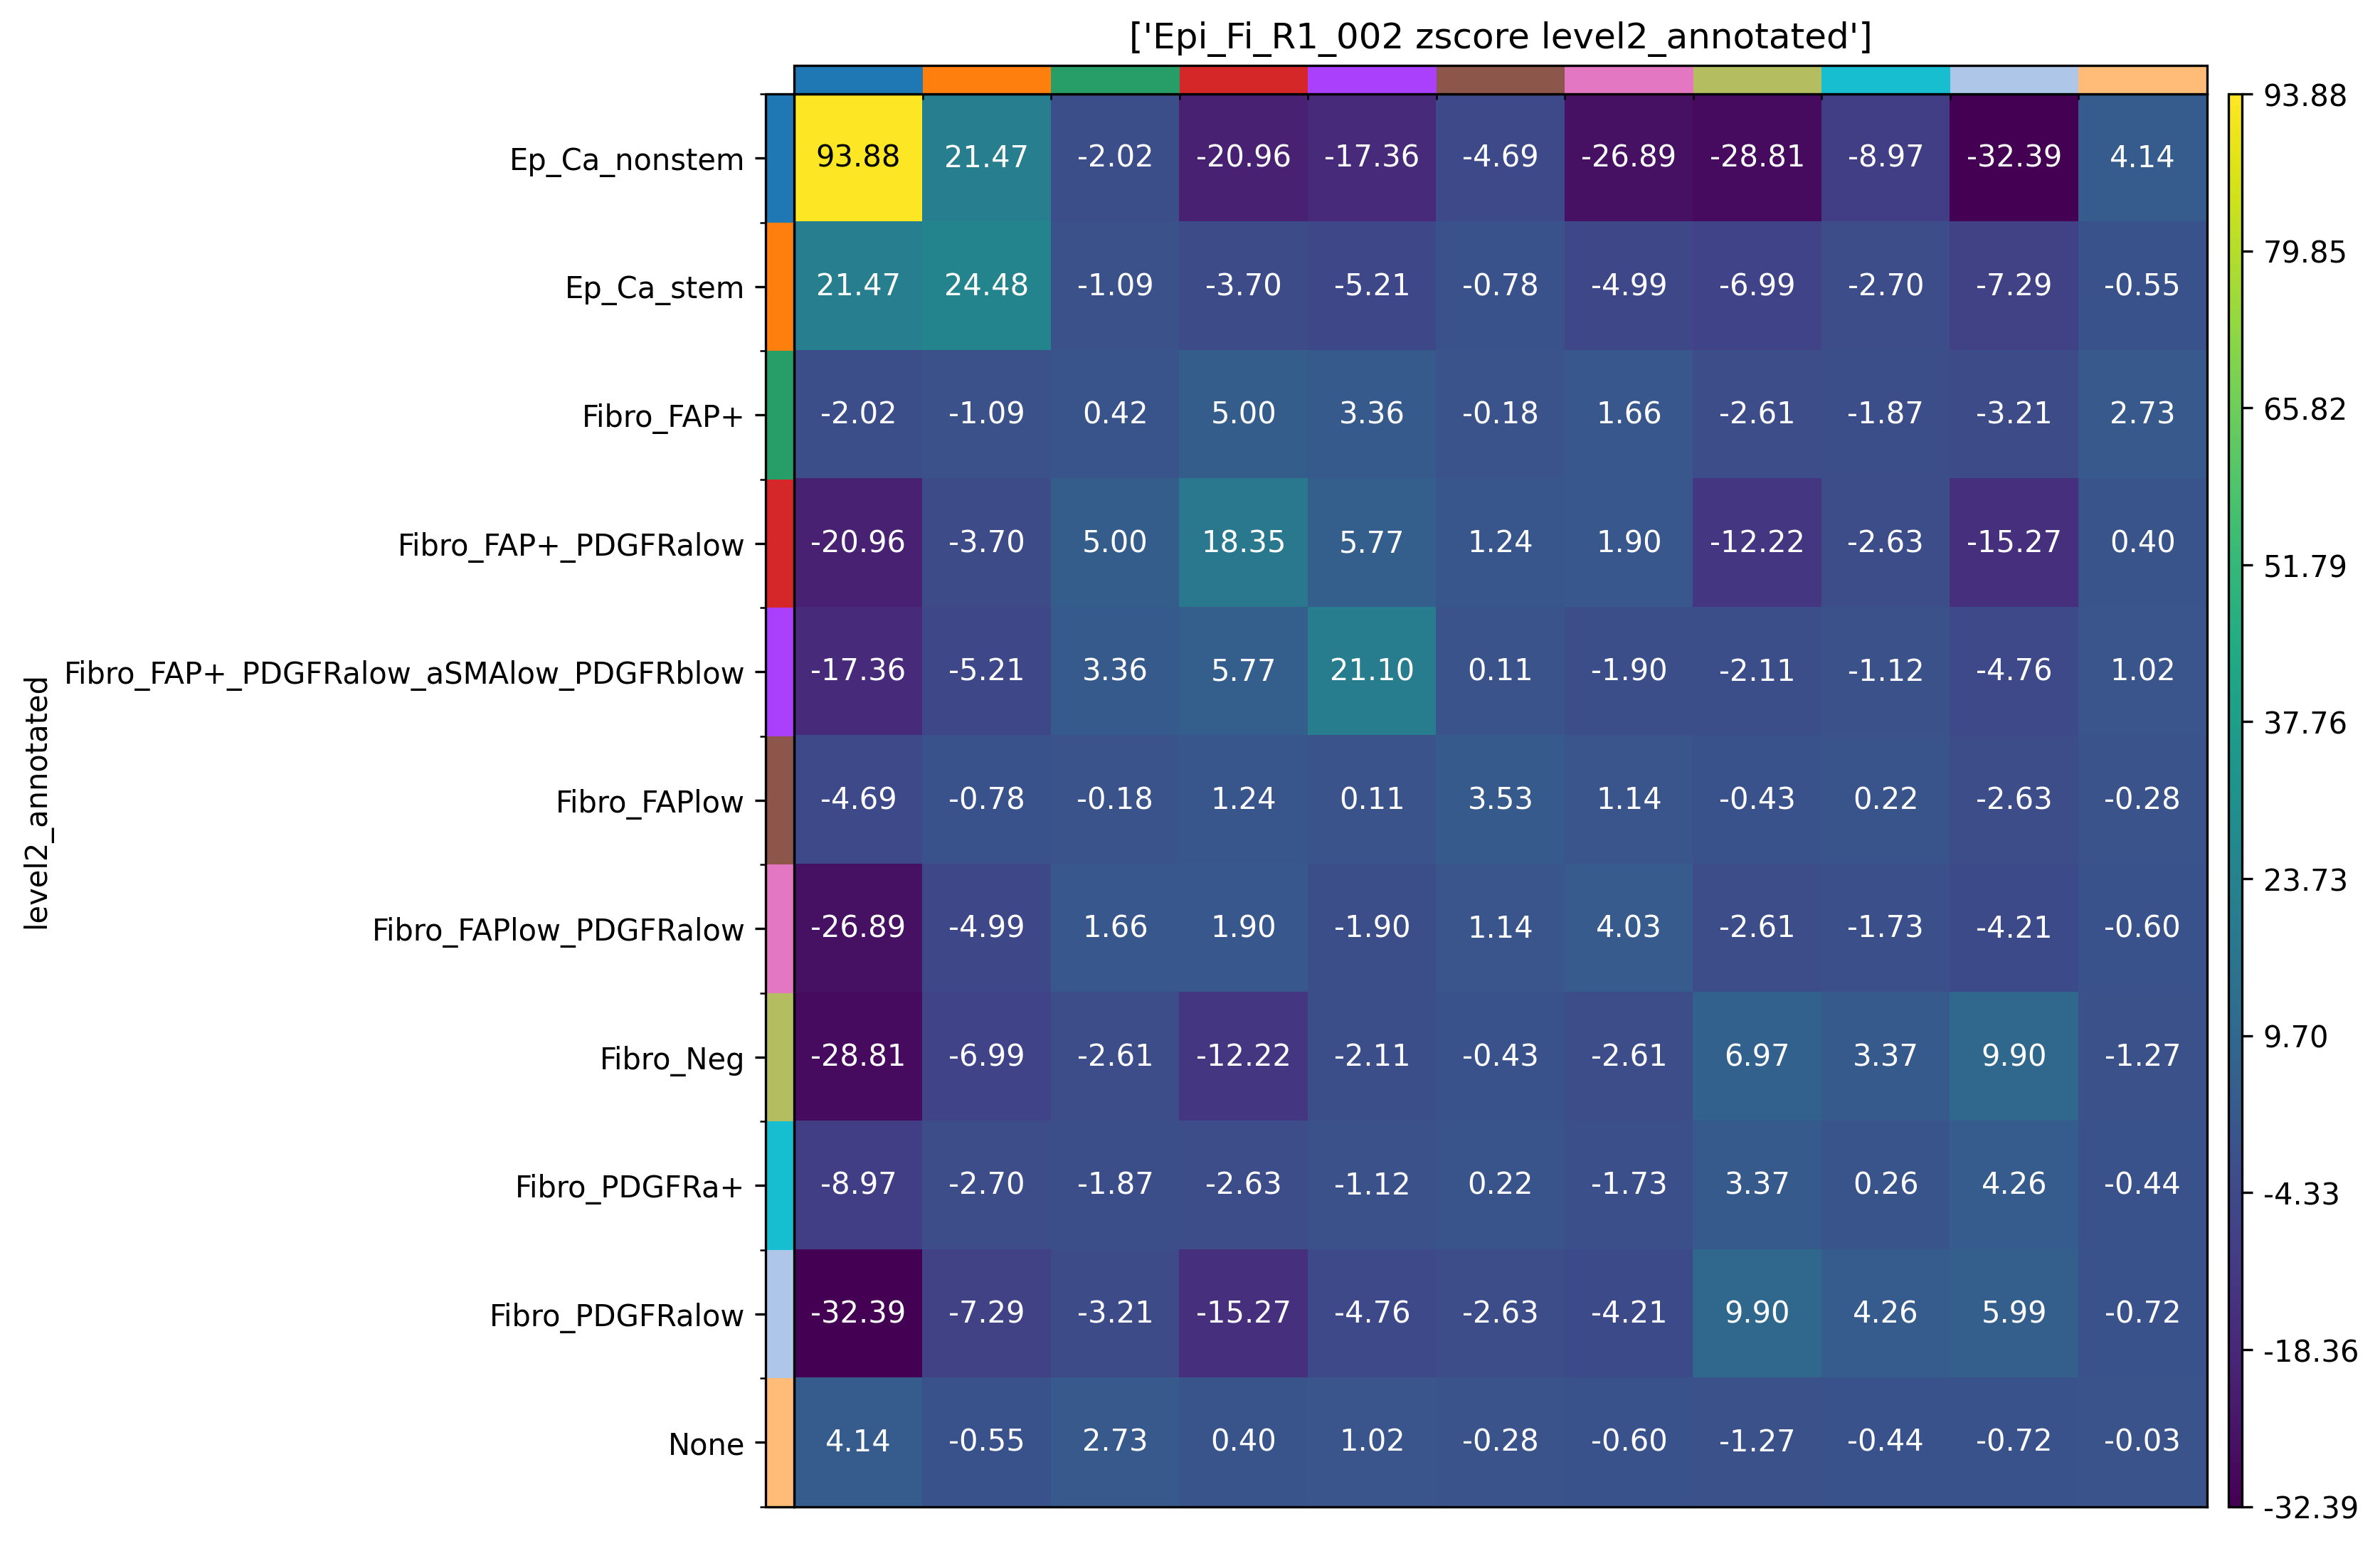

<Figure size 800x500 with 0 Axes>

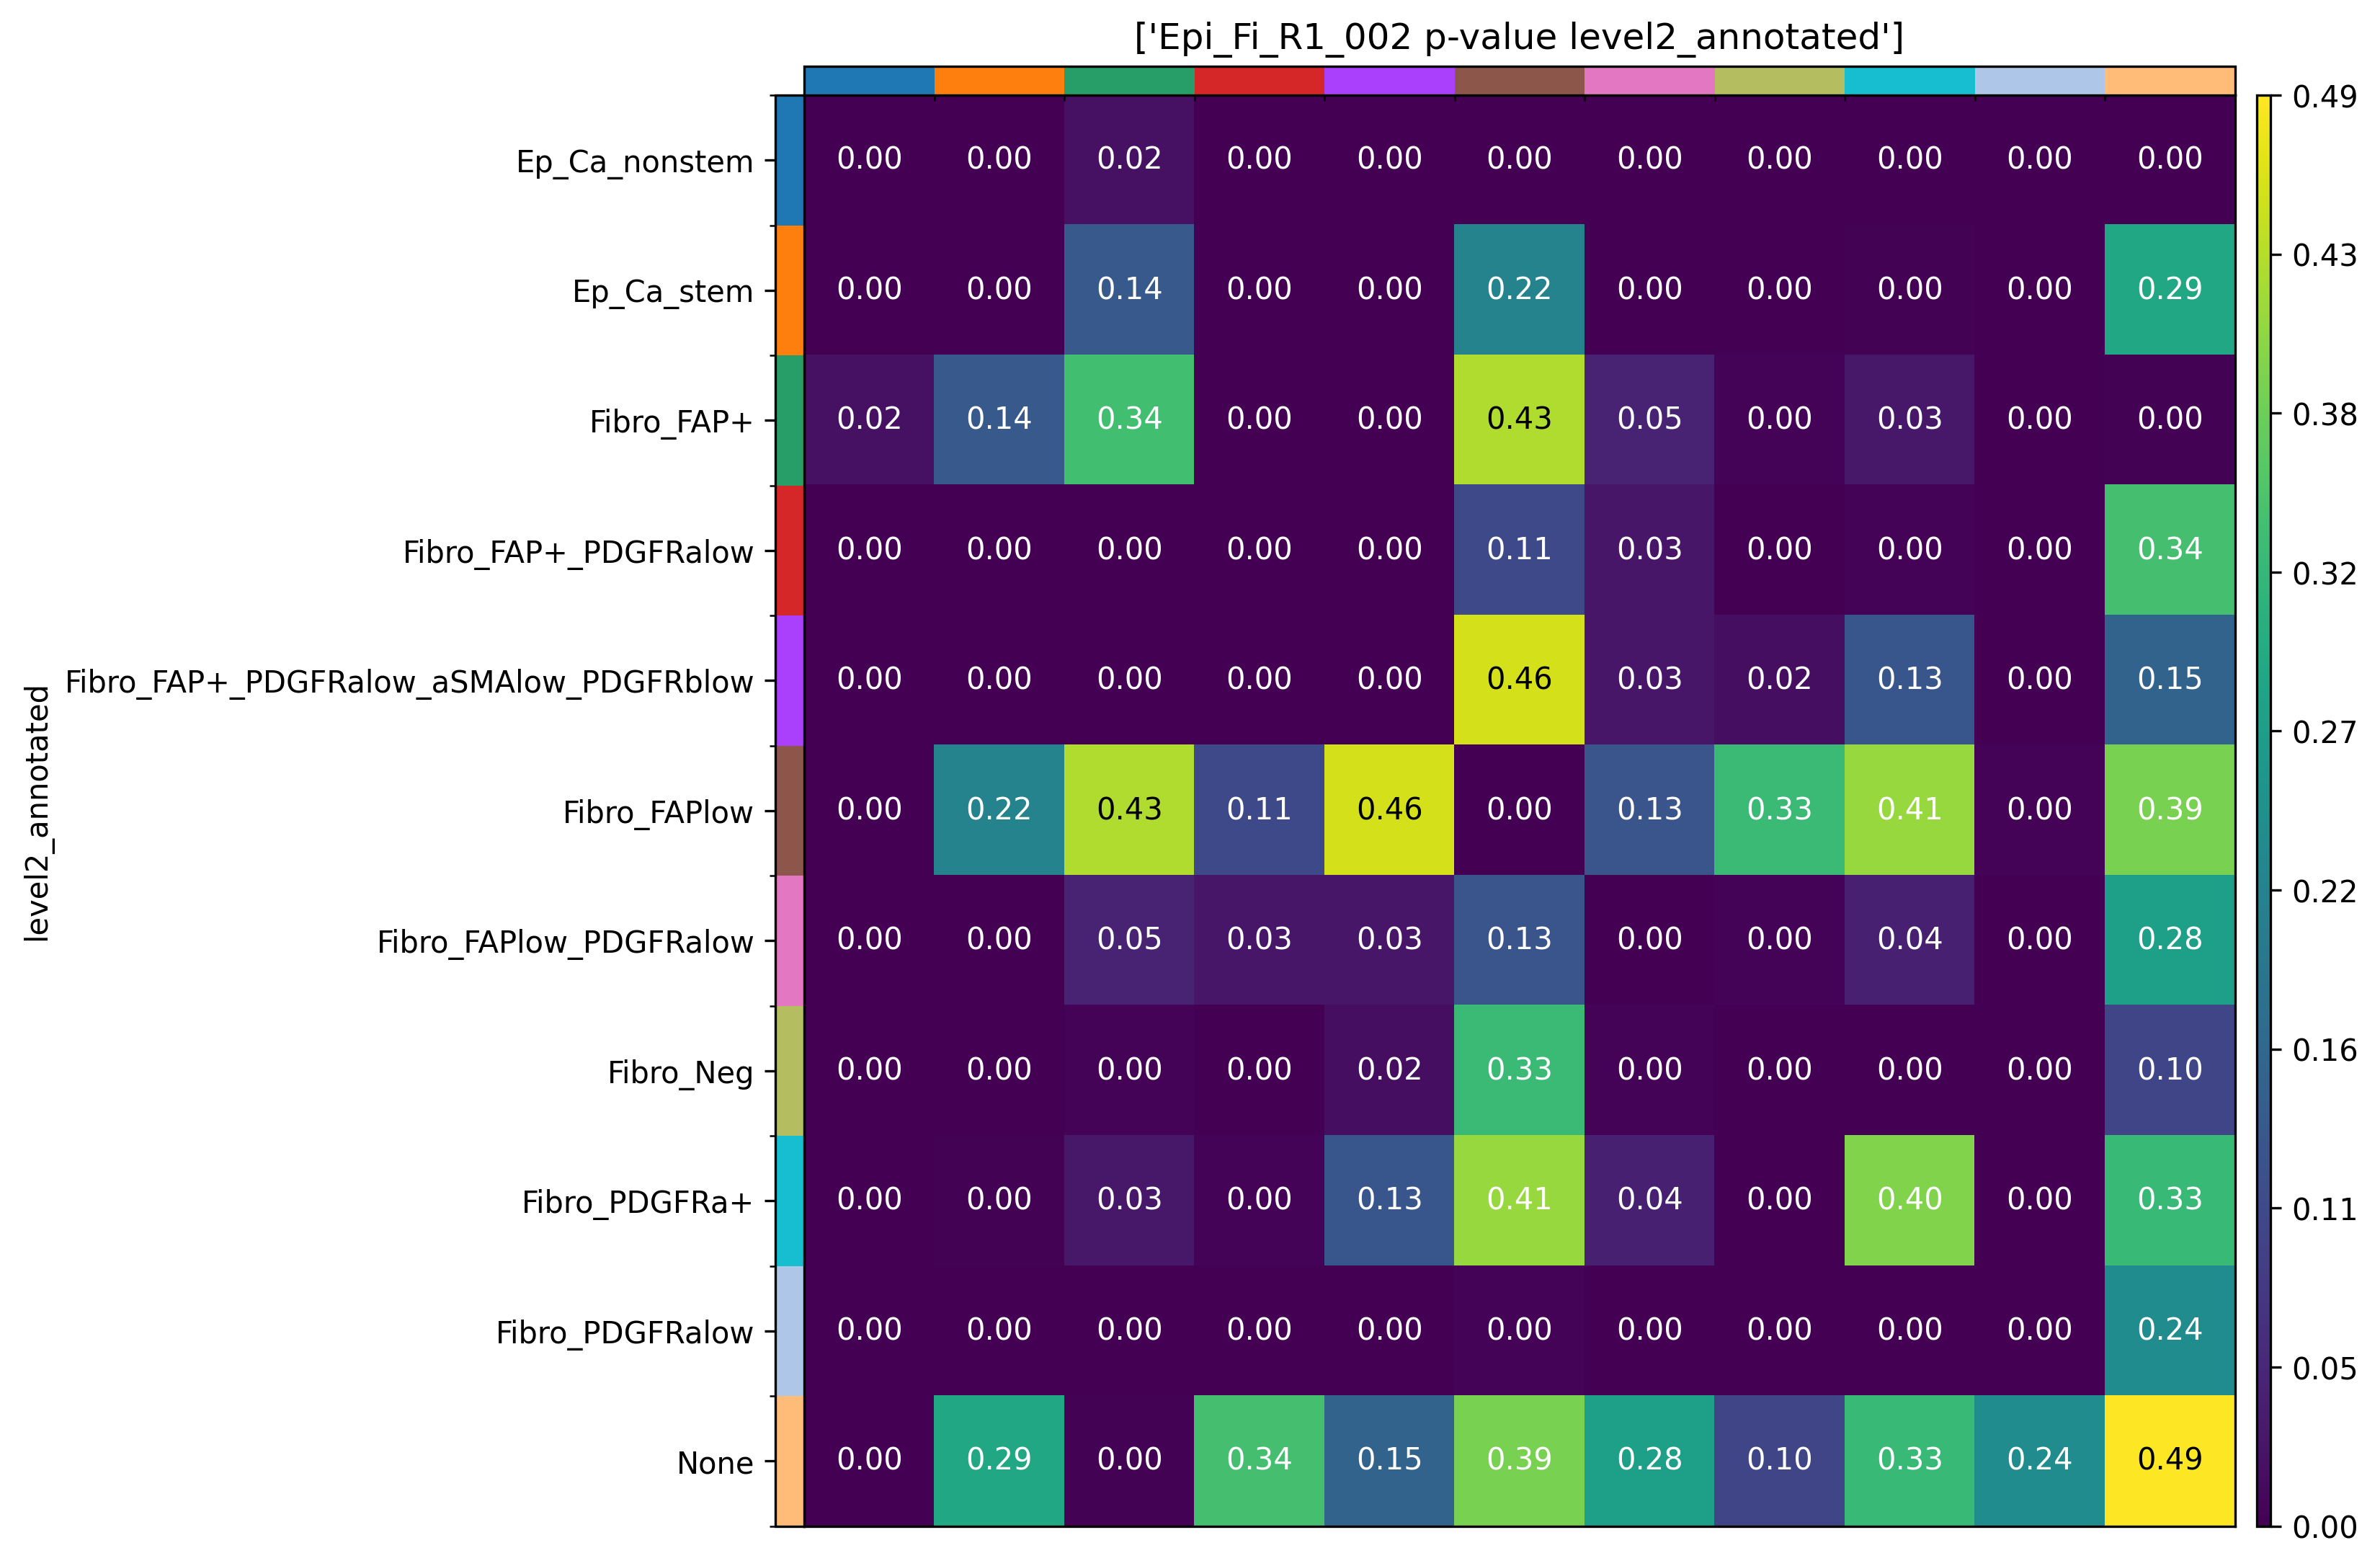

<Figure size 800x500 with 0 Axes>

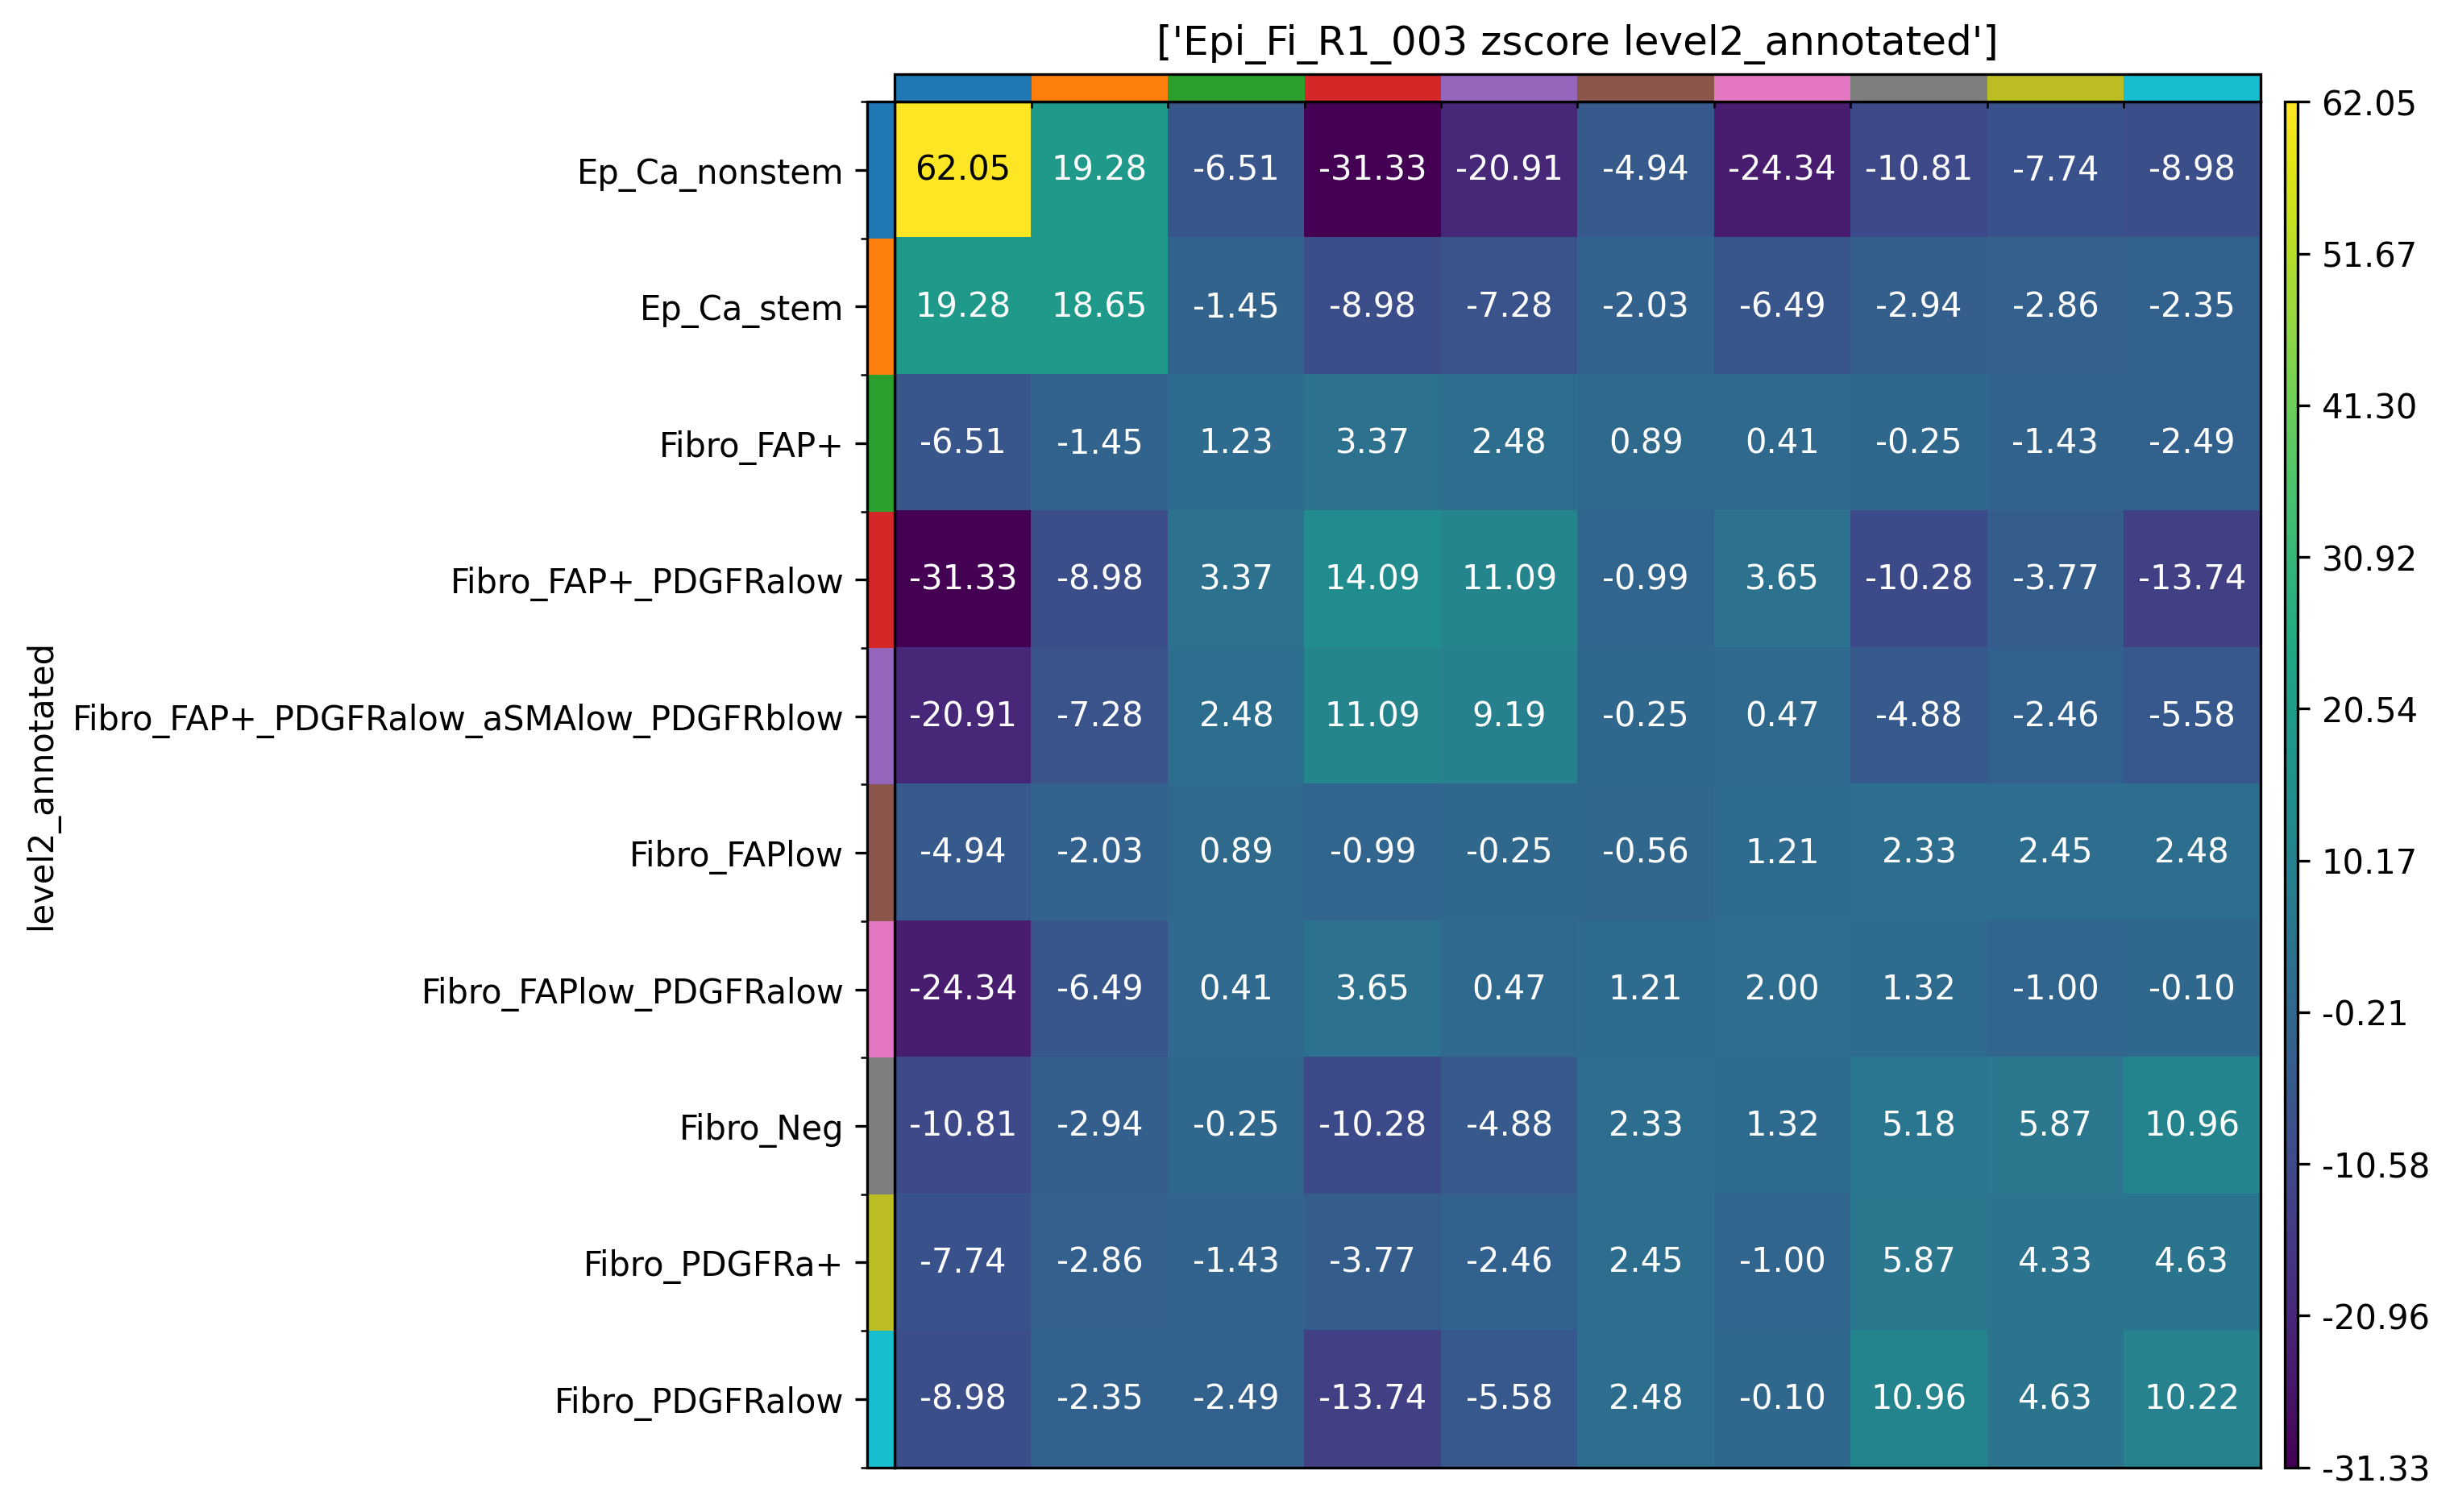

<Figure size 800x500 with 0 Axes>

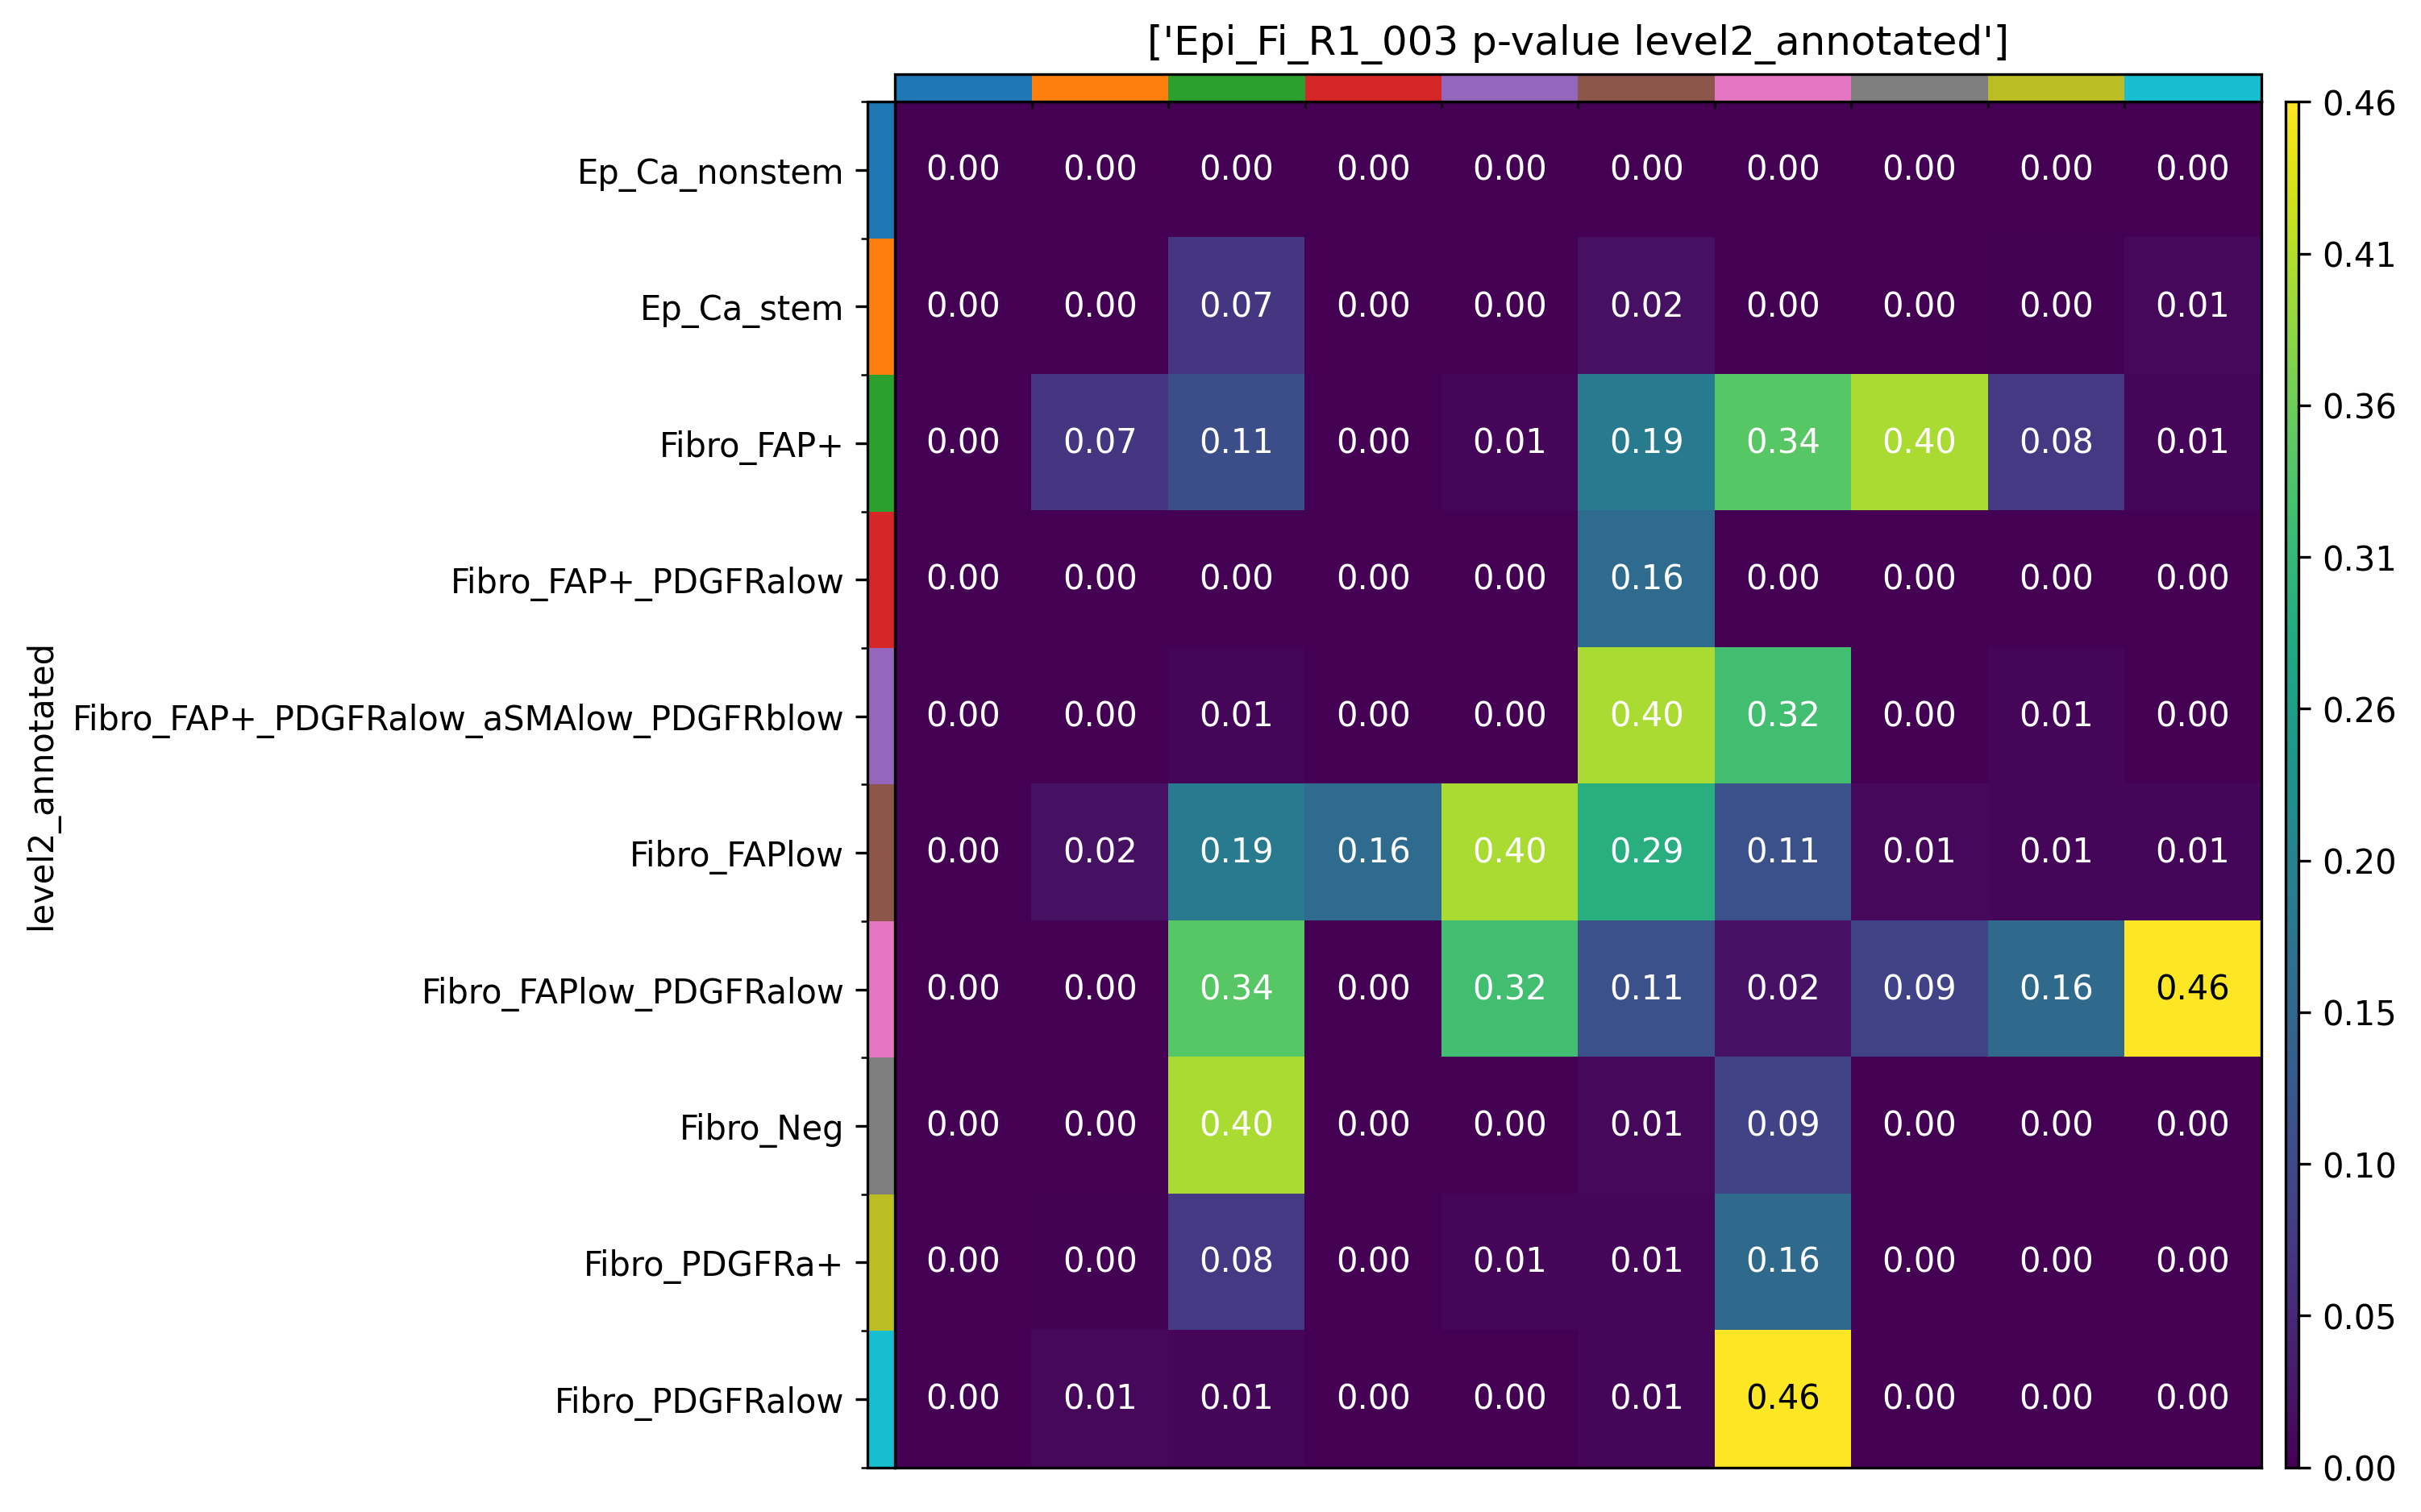

In [15]:
# You can change radius (pixel)
radius = 15
for img in Epi_Fi_adata.obs['img_id'].unique():
    img_adata = Epi_Fi_adata[Epi_Fi_adata.obs['img_id'] == img]
    run_spatial_nhood(img_adata, 'level2_annotated', radius =radius)
    # calculate pvalue from zscore and save to uns
    img_adata.uns['level2_annotated_nhood_enrichment']['pval'] = z_to_pvalue(img_adata.uns['level2_annotated_nhood_enrichment']['zscore'])
    plt_spatial_nhood(img_adata, 'level2_annotated', 'output/', 'Epi_Fi_'+img)
    plt_spatial_pval(img_adata, 'level2_annotated', 'output/', 'Epi_Fi_'+img)
    ut.save_pickle_obj('output/02hanna_adata_Patient9_obj_Epi_Fi_level2_spatial_'+img+'.pkl', img_adata)

Text(0.5, 1.0, 'pvalue')

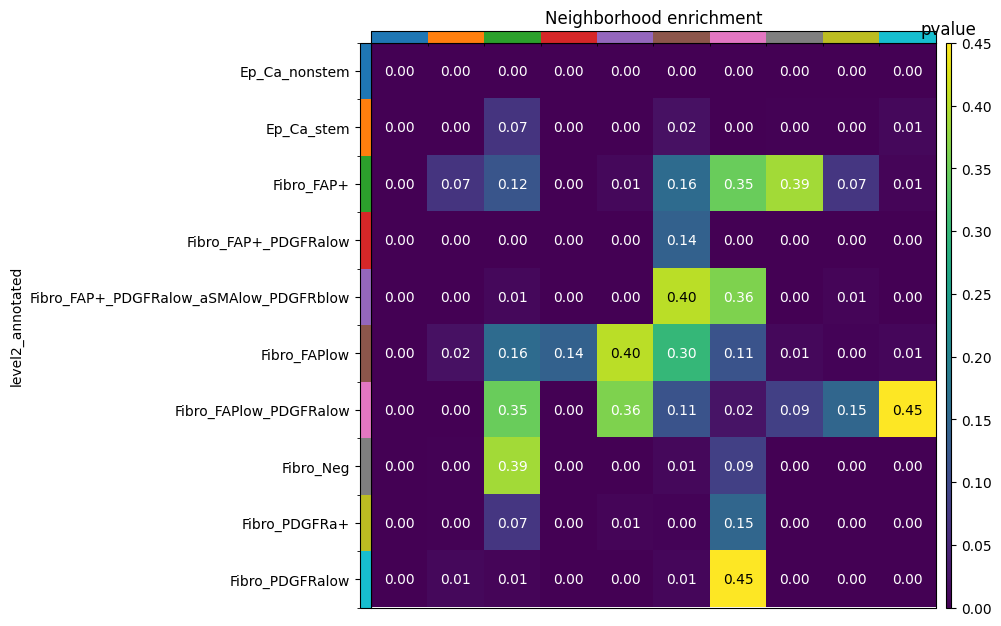

In [16]:
sq.pl.nhood_enrichment(img_adata, cluster_key = 'level2_annotated', mode='pval', annotate=True)
plt.title('pvalue')

## spatial plot with list of cell name

In [22]:
# Provide input list of cell names for spatial plot
Cell_list = ['Ep_Ca_nonstem', 'Fibro_PDGFRa+', 'Fibro_FAP+_PDGFRalow']

In [32]:
('_').join(Cell_list)

'Ep_Ca_nonstem_Fibro_PDGFRa+_Fibro_FAP+_PDGFRalow'

In [36]:
def plt_spatial_cell_list(adata, cell_list, obs_col, output_path, name):
    filtered_adata = adata[adata.obs[obs_col].isin(cell_list)]
    for img in filtered_adata.obs['img_id'].unique():
        img_adata = filtered_adata[filtered_adata.obs['img_id'] == img]
        plt_spatial(img_adata, obs_col, output_path, name+'_'+img)

/Users/pattama/Desktop/UiB/venv_folder/IMCprocess_venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/pattama/Desktop/UiB/venv_folder/IMCprocess_venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/pattama/Desktop/UiB/venv_folder/IMCprocess_venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/pattama/Desktop/UiB/venv_folder/IMCprocess_venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/pattama/Desktop/UiB/venv_folder/IMCprocess_venv/lib/python3.8/site-packages/a

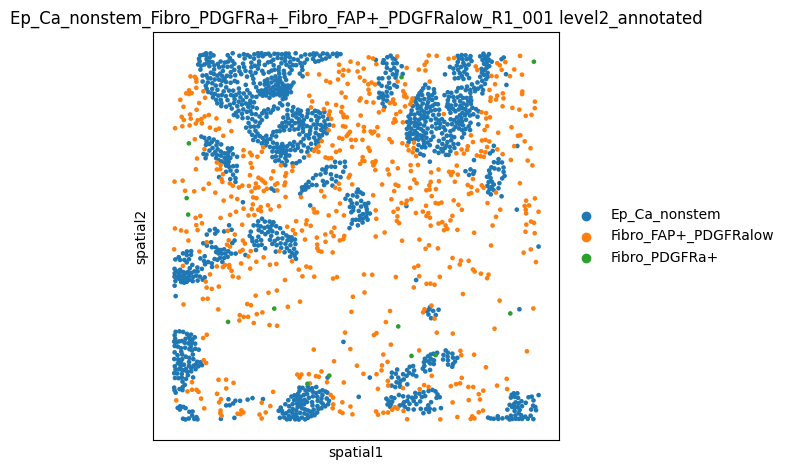

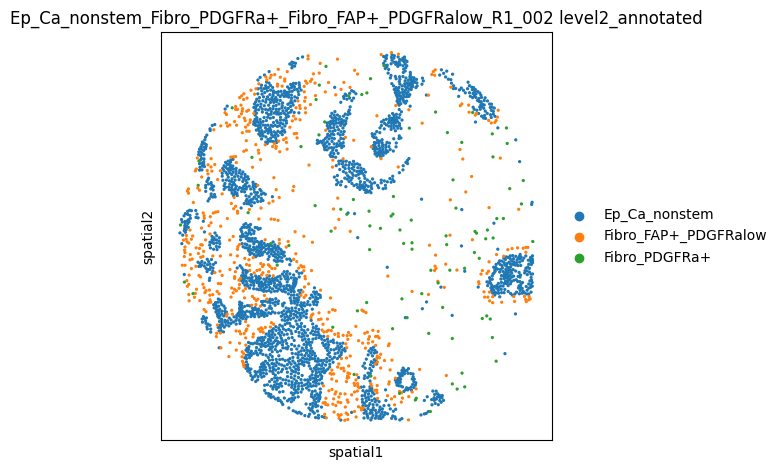

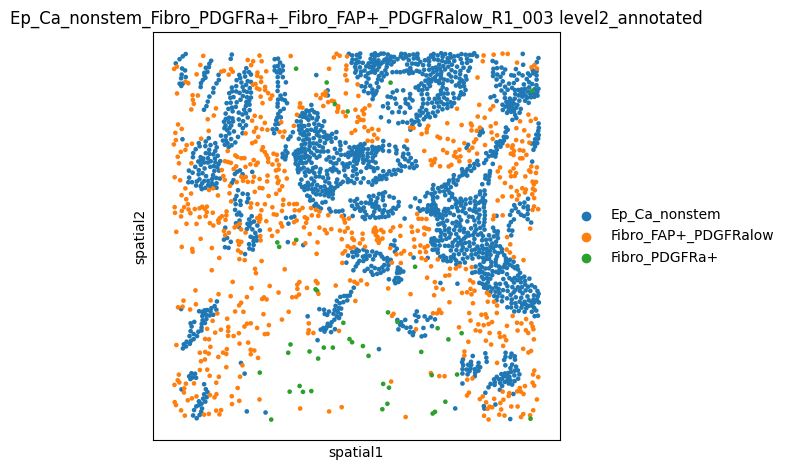

In [37]:
plt_spatial_cell_list(Epi_Fi_adata, Cell_list, 'level2_annotated', 'output/', ('_').join(Cell_list))